# Multi-agent network
- 출처 : https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/multi_agent/multi-agent-collaboration.ipynb
- 수정사항 : 한글화 및 일부 내용 수정


## 필수 패키지 설치

In [16]:
%%capture --no-stderr
%pip install -U langchain_community langchain_openai langchain_anthropic langchain_experimental matplotlib langgraph


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


##  API 키 설정
o OPENAI_API_KEY : https://platform.openai.com/api-keys   
o ANTHROPIC_API_KEY : https://console.anthropic.com/settings/keys  
o TAVILY_API_KEY : https://app.tavily.com/home : API Keys

In [17]:
import getpass
import os


# def _set_if_undefined(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"Please provide your {var}")


# _set_if_undefined("ANTHROPIC_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")


def get_api_key(var_name: str) -> str:
    value = os.getenv(var_name)
    if not value:
        raise EnvironmentError(f"{var_name} 환경변수가 설정되어 있지 않습니다.")
    return value

# 사용 예시
anthropic_key = get_api_key("ANTHROPIC_API_KEY")
tavily_key = get_api_key("TAVILY_API_KEY")

## 도구(Tool) 정의
에이전트가 사용할 도구를 정의(Define)

In [26]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## 그래프 만들기
이제 도구를 정의하고 일부 helper function을 만들었으므로 아래의   
개별 에이전트를 만들고 LangGraph를 사용하여 서로 대화하는 방법을 알려줍니다.

### 에이전트 노드 정의
먼저 각 에이전트에 대한 시스템 프롬프트를 만드는 유틸리티를 만듭니다.

In [27]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

"당신은 다른 어시스턴트들과 협업하는 유용한 AI 어시스턴트입니다."  
"제공된 도구를 사용하여 질문에 대한 답변을 진행하세요."   
"완전히 답변할 수 없어도 괜찮습니다. 다른 도구를 사용하는 다른 어시스턴트가 "  
" 중단한 부분부터 도와드릴 것입니다. 진행을 위해 할 수 있는 일을 실행하세요."   
"당신이나 다른 어시스턴트 중 누군가가 최종 답변이나 제공물을 가지고 있는 경우,"  
"팀이 중단해야 한다는 것을 알 수 있도록 답변 앞에 FINAL ANSWER를 붙여주세요."

In [20]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


llm = ChatOpenAI(model="gpt-4o")
# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

### 그래프 정의
이제 모든 것을 모아 그래프를 정의합니다.

In [21]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

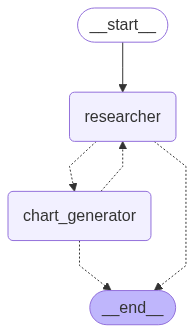

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 호출(Invoke)
그래프가 생성되었으니 호출할 수 있습니다!  
몇 가지 통계를 차트로 표시해 보겠습니다.

{'researcher': {'messages': [HumanMessage(content="First, get the KOREA's GDP over the past 10 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='13c5ff4a-18be-47b7-9a9c-9d3414be1a91'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_abZmm7l40K9WiavikzlATfUF', 'function': {'arguments': '{"query":"South Korea GDP last 10 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 211, 'total_tokens': 235, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BfwvNVFSzCAGYo3nk5dvDIuloAoge', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs'

Python REPL can execute arbitrary code. Use with caution.


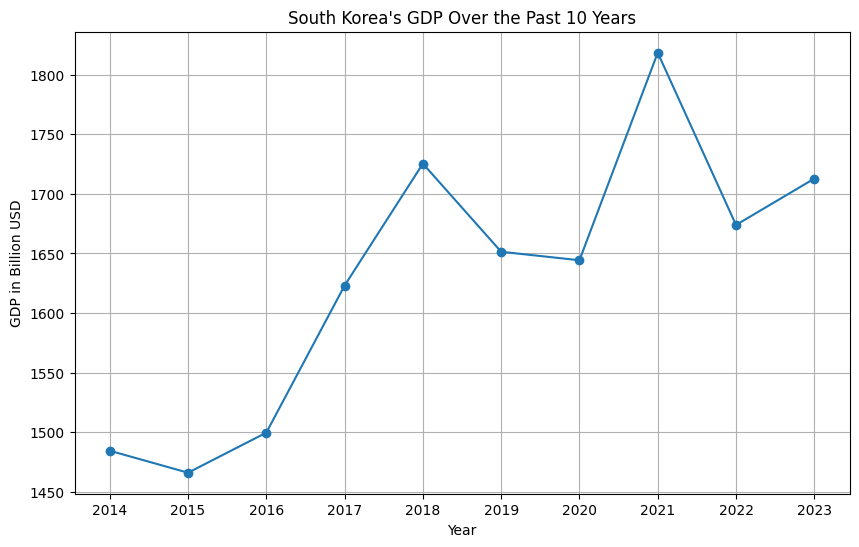

{'chart_generator': {'messages': [HumanMessage(content="First, get the KOREA's GDP over the past 10 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='13c5ff4a-18be-47b7-9a9c-9d3414be1a91'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_abZmm7l40K9WiavikzlATfUF', 'function': {'arguments': '{"query":"South Korea GDP last 10 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 211, 'total_tokens': 235, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BfwvNVFSzCAGYo3nk5dvDIuloAoge', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logp

In [23]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the KOREA's GDP over the past 10 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

# AI Agent

## Langgraph - Web search + LLM = 검색 Chatbot

- Tool을 호출하고 그 결과를 모델(LLM)로 전달하기

- https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-2-enhancing-the-chatbot-with-tools

In [ ]:
# # Example: Passing tool outputs to model
# from langchain_core.tools import tool

# @tool
# def add(a: int, b: int) -> int:
#     """Adds a and b.

#     Args:
#         a: first int
#         b: second int
#     """
#     return a + b

# @tool
# def multiply(a: int, b: int) -> int:
#     """Multiplies a and b.

#     Args:
#         a: first int
#         b: second int
#     """
#     return a * b

# tools = [add, multiply]

In [70]:
# chatbot
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

class State(TypedDict): # 그래프의 상태를 정의하는 클래스
    messages: Annotated[list, add_messages] # 메시지 누적

graph_builder = StateGraph(State) # StateGraph 생성 (대화 흐름 관리)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [71]:
# tool
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """
        A node that runs the tools requested in the last AIMessage.
        마지막 AIMessage에서 요청된 도구를 실행하는 노드
    """

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools} # ["tavily_search_results_json" : TavilySearchResults()]

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1] # 마지막 message
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls: # 메시지에서 호출된 도구를 불러옴
            tool_result = self.tools_by_name[tool_call["name"]].invoke( # Tool 호출 실행
                tool_call["args"]
            )
            outputs.append( # Tool 호출 결과(ToolMessage) 추가
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [72]:
# edge
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0: # if the last message has "tool_calls"
        return "tools"
    return END

# 조건부 엣지 연결
graph_builder.add_conditional_edges(
    "chatbot", # 시작 노드
    route_tools,
    {"tools": "tools", END: END}, # 반환값이 "tools" 면 "tools" 노드로, END 면 END로 이동
)

In [73]:
# 엣지 연결
graph_builder.add_edge("tools", "chatbot") # 도구가 호출될 때마다 챗봇으로 돌아가 다음 단계를 결정
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

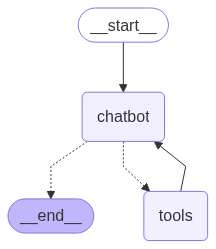

In [74]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [75]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}): # graph 노드 호출 결과 받아옴
        for value in event.values():
            print("Assistant:", value["messages"][-1].content) # AI 답변 출력

In [76]:
while True:
    try:
        user_input = input("User: ")
        print("User: " + user_input)
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hi
Assistant: Hello! How can I assist you today?
User: what is lessearfim
Assistant: 
Assistant: [{"title": "LE SSERAFIM Members Profile (Updated!) - Kpop Profiles", "url": "https://kprofiles.com/le-sserafim-members-profile/", "content": "LE SSERAFIM (\ub974\uc138\ub77c\ud54c) is a 5-member girl group under HYBE and Source Music. The members currently consist of Kim Chaewon, Sakura, Huh Yunjin,", "score": 0.8467682}, {"title": "LE SSERAFIM \ub974\uc138\ub77c\ud54c \uacf5\uc2dd \ud648\ud398\uc774\uc9c0 - SOURCE MUSIC", "url": "https://www.sourcemusic.com/artist/profile/LE%20SSERAFIM", "content": "LE SSERAFIM is a girl group with SOURCE MUSIC, a label under HYBE, consisting of five members of different nationalities: SAKURA,", "score": 0.8449346}]
Assistant: LE SSERAFIM is a 5-member girl group under the label HYBE and Source Music. The group consists of members from different nationalities including Kim Chaewon, Sakura, and Huh Yunjin among others. For more details, you can visit 